# bt backtesting

- https://github.com/pmorissette/bt
- https://pmorissette.github.io/bt/

In [1]:
%pip install --upgrade numpy
%pip install --upgrade pandas
%pip install --upgrade matplotlib
%pip install --upgrade yfinance
%pip install --upgrade PyPortfolioOpt
%pip install --upgrade ffn
%pip install --upgrade bt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e9/43/93ea65227c938a0a4a8925d7f054b050ea743044b887170da9eca210635a/yfinance-0.2.28-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.27
    Uninstalling yfinance-0.2.27:
      Successfully uninstalled yfinance-0.2.27
Note: you may need to restart the kernel to

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import ffn
import bt
from datetime import timedelta
%matplotlib inline

## Load data

In [3]:
# Fixes https://github.com/pmorissette/ffn/issues/185
# yf.pdr_override()
# data = ffn.get('agg,hyg,spy,eem,efa', start='2013-01-01', end='2018-01-01') # also bt.get
# data.head()

In [4]:
stocks = ["SPY", "AGG", "GLD"]
data = yf.download(stocks, period='10y')["Adj Close"]
data

[*********************100%***********************]  3 of 3 completed


,AGG,GLD,SPY
Date,,,
2013-03-25,87.004608,155.240005,128.772522
2013-03-26,87.107079,154.720001,129.803040
2013-03-27,87.288376,155.360001,129.803040
2013-03-28,87.288376,154.449997,130.201920
2013-04-01,87.367401,154.669998,129.686707
...,...,...,...
2023-03-20,99.099998,183.839996,393.739990
2023-03-21,98.800003,180.369995,398.910004
2023-03-22,99.750000,183.440002,392.109985


## 50/30/20 Portfolio

- https://medium.com/@richardhwlin/flexible-backtesting-with-bt-7295c0dde5dd

In [5]:
p503020_strategy = bt.Strategy('p503020', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(AGG=0.3,GLD=0.2,SPY=0.5),
    bt.algos.Rebalance(),
])
# create a backtest
p503020W_test = bt.Backtest(p503020_strategy, data)

## Equally Weighted

In [6]:
# create the strategy
EW_strategy = bt.Strategy('EW', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
# create a backtest
EW_test = bt.Backtest(EW_strategy, data)


## Randomly weighted

In [7]:
# create our new strategy
Random_strategy = bt.Strategy('Random', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighRandomly(),
    bt.algos.Rebalance()
])

# create a backtest
Random_test = bt.Backtest(Random_strategy, data)

## MeanVar

In [8]:
# create our new strategy
MeanVar_strategy = bt.Strategy('MeanVar', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=365)),
    bt.algos.SelectAll(),
    bt.algos.WeighMeanVar(lookback=pd.DateOffset(years=1),),
    bt.algos.Rebalance()
])

# create a backtest
MeanVar_test = bt.Backtest(MeanVar_strategy, data)

## ERC

In [9]:
# create our new strategy
ERC_strategy = bt.Strategy('ERC', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=365)),
    bt.algos.SelectAll(),
    bt.algos.WeighERC(lookback=pd.DateOffset(years=1),),
    bt.algos.Rebalance()
])

# create a backtest
ERC_test = bt.Backtest(ERC_strategy, data)

## Inverse Volatility

In [10]:
# create our new strategy
InvVol_strategy = bt.Strategy('InvVol', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighInvVol(),
    bt.algos.Rebalance()
])

# create a backtest
InvVol_test = bt.Backtest(InvVol_strategy, data)

## Momentum

In [11]:
# create our new strategy
Momentum_strategy = bt.Strategy('Momentum', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=92)),
    bt.algos.SelectAll(),
    bt.algos.SelectMomentum(n=4,lookback=pd.DateOffset(months=3)),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# create a backtest
Momentum_test = bt.Backtest(Momentum_strategy, data)

## My Algo

In [12]:
from pypfopt import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import risk_models

class MyWeights(bt.Algo):
    """
    TODO
    """

    def __init__(self):
        super(MyWeights, self).__init__()

    def __call__(self, target):
        df=target.universe.dropna()
        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
        #S = risk_models.exp_cov(df)

        # Optimize for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S)
        #ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        ef.add_constraint(lambda w: w >= 0.1)
        
        ef.max_sharpe()
        weights = ef.clean_weights()
        #print(weights)

        target.temp['weights'] = weights
        return True

In [13]:
# create our new strategy
MyWeights_strategy = bt.Strategy('MyWeights', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=3)),
    bt.algos.SelectAll(),
    MyWeights(),
    bt.algos.Rebalance()
])

# create a backtest
MyWeights_test = bt.Backtest(MyWeights_strategy, data)

## Compute and plot

In [14]:
# we include test here to see the results side-by-side
report = bt.run(
    p503020W_test,
    EW_test,
    Random_test,
    MeanVar_test,
    ERC_test,
    InvVol_test,
    Momentum_test,
    MyWeights_test
)

c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init

<Axes: title={'center': 'Equity Progression'}>

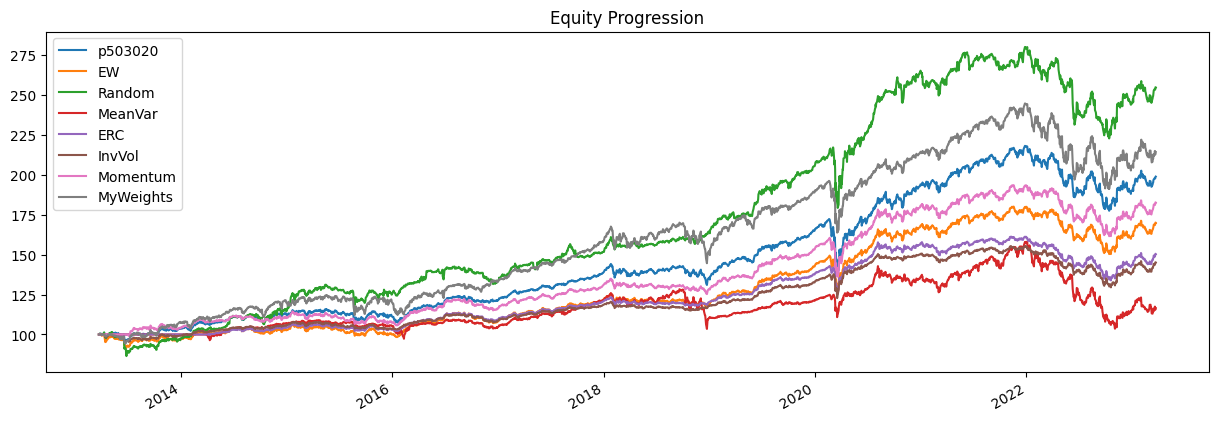

In [15]:
report.plot()

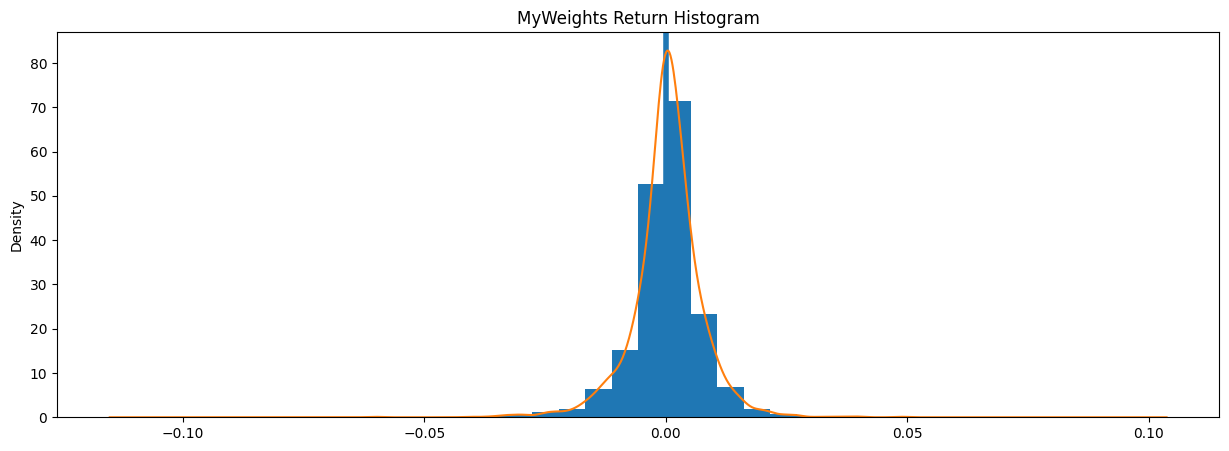

In [16]:
# Let's chart the return distribution
report.plot_histogram('MyWeights')

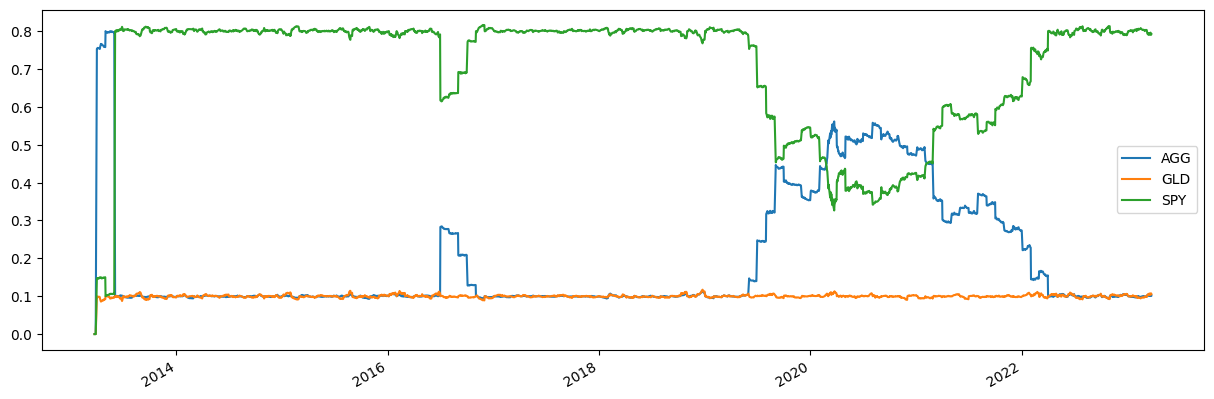

In [17]:
# Let's plot the security weights over time
report.plot_security_weights('MyWeights')

In [18]:
report.display()

Stat                 p503020     EW          Random      MeanVar     ERC         InvVol      Momentum    MyWeights
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2013-03-24  2013-03-24  2013-03-24  2013-03-24  2013-03-24  2013-03-24  2013-03-24  2013-03-24
End                  2023-03-24  2023-03-24  2023-03-24  2023-03-24  2023-03-24  2023-03-24  2023-03-24  2023-03-24
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         98.80%      69.83%      154.59%     16.50%      50.31%      45.07%      82.47%      114.19%
Daily Sharpe         0.77        0.68        0.91        0.20        0.70        0.69        0.79        0.71
Daily Sortino        1.18        1.06        1.44        0.29        1.07        1.06        1.24        1.11
CAGR                 7.11%       5.44%       9.80%       1.54%       4.16%       3.79%     

TODO:
- https://medium.com/@richardhwlin/flexible-backtesting-with-bt-7295c0dde5dd
- https://medium.com/@richardhwlin/advanced-backtesting-with-bt-635ed441cb60